In [1]:
 from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

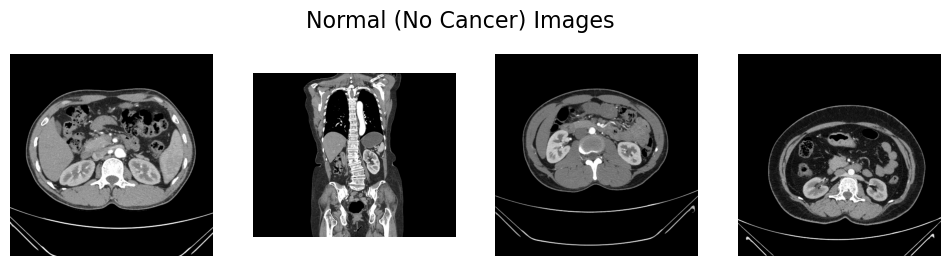

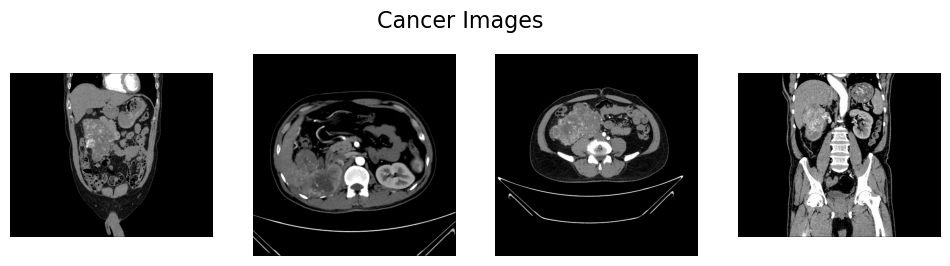

Total 'Normal (No Cancer)' images: 5077
Total 'Cancer' images: 2285


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define dataset paths
dataset_path = r"C:\Users\pc\Music\Kidney cancer detection\Dataset"
cancer_path = os.path.join(dataset_path, 'Cancer')  
normal_path = os.path.join(dataset_path, 'Normal')   

# Check if folders exist
if not os.path.exists(cancer_path) or not os.path.exists(normal_path):
    print("Error: One or both dataset folders do not exist.")
else:
    # Get unique images from each folder
    cancer_files = list(set(os.listdir(cancer_path)))  # Remove duplicates
    normal_files = list(set(os.listdir(normal_path)))  # Remove duplicates

    # Shuffle to pick random different images
    random.shuffle(cancer_files)
    random.shuffle(normal_files)

    # Select up to 4 unique images
    cancer_images = cancer_files[:4] if len(cancer_files) >= 4 else cancer_files
    normal_images = normal_files[:4] if len(normal_files) >= 4 else normal_files

    # Convert filenames to full file paths
    cancer_images = [os.path.join(cancer_path, img) for img in cancer_images]
    normal_images = [os.path.join(normal_path, img) for img in normal_images]

    # Function to display images
    def display_images(image_paths, title):
        if not image_paths:
            print(f"No images found for {title}.")
            return
        
        fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 3))
        fig.suptitle(title, fontsize=16)

        for ax, img_path in zip(axes, image_paths):
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.axis("off")
            except FileNotFoundError:
                print(f"File not found: {img_path}")

        plt.show()

    # Display images
    display_images(normal_images, "Normal (No Cancer) Images")
    display_images(cancer_images, "Cancer Images")

    # Print total count of images
    print(f"Total 'Normal (No Cancer)' images: {len(normal_files)}")
    print(f"Total 'Cancer' images: {len(cancer_files)}")


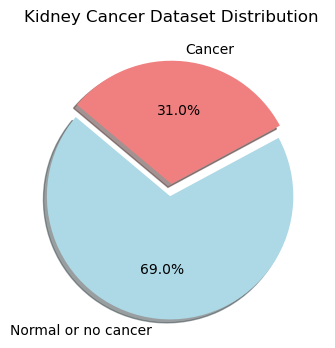

In [3]:
import os
import matplotlib.pyplot as plt

# Define dataset paths
no_path = r"C:\Users\pc\Music\Kidney cancer detection\Dataset\Normal"
yes_path = r"C:\Users\pc\Music\Kidney cancer detection\Dataset\Cancer"

# Count total images in each category
no_count = len(os.listdir(no_path))
yes_count = len(os.listdir(yes_path))

# Labels and sizes for the pie chart
labels = ['Normal or no cancer ', 'Cancer']
sizes = [no_count, yes_count]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # Highlight the 'No Cancer' category

# Create pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=140)
plt.title("Kidney Cancer Dataset Distribution")

# Show the chart
plt.show()


In [4]:
def crop_kidney_contour(image, plot=False):

    import cv2
    import imutils
    from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

    

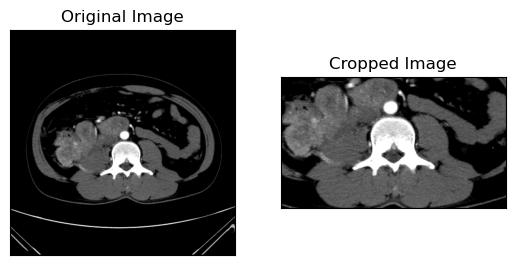

In [5]:
image_path = r'C:\Users\pc\Music\Kidney cancer detection\Dataset\Cancer\cancer_1002.jpg'

ex_img = cv2.imread(image_path)

if ex_img is not None:
    ex_new_img = crop_kidney_contour(ex_img, True)
else:
    print("Error: Image not loaded. Check the path.")


In [6]:
def crop_kidney_contour(image, plot=False):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image
    _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)

    # Morphological operations to clean up
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image  # Return original if no contour found

    # Find the largest contour
    c = max(contours, key=cv2.contourArea)

    # Get bounding box and crop
    x, y, w, h = cv2.boundingRect(c)
    cropped = image[y:y+h, x:x+w]

    if plot:
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped")
        plt.show()

    return cropped


In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        label = 1 if 'Cancer' in directory.split("\\")[-1] else 0  # Explicitly check folder name

        for filename in listdir(directory):
            image_path = directory + '\\' + filename
            image = cv2.imread(image_path)

            if image is None:
                continue

            # Crop kidney region
            image = crop_kidney_contour(image, plot=False)

            # Resize and normalize
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_AREA)
            image = image / 255.

            X.append(image)
            y.append([label])  # Use label based on folder name

    # Convert to numpy arrays (with memory efficiency)
    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [8]:
augmented_cancer = r'C:\Users\pc\Music\Kidney cancer detection\Dataset\Cancer'
augmented_normal = r'C:\Users\pc\Music\Kidney cancer detection\Dataset\Normal'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_cancer, augmented_normal], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 7362
X shape is: (7362, 240, 240, 3)
y shape is: (7362, 1)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    for label in [0, 1]:
        indices = np.argwhere(y == label).flatten()  # ✅ flatten avoids extra dimension
        selected_indices = indices[:n]
        n_images = X[selected_indices]

        columns_n = 10
        rows_n = int(np.ceil(n / columns_n))

        plt.figure(figsize=(20, 5))
        for i, img in enumerate(n_images):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(img)
            plt.axis('off')

        label_str = "Cancer" if label == 1 else " ( Normal: No Cancer)"
        plt.suptitle(f"kidney Cancer: {label_str}")
        plt.tight_layout()
        plt.show()


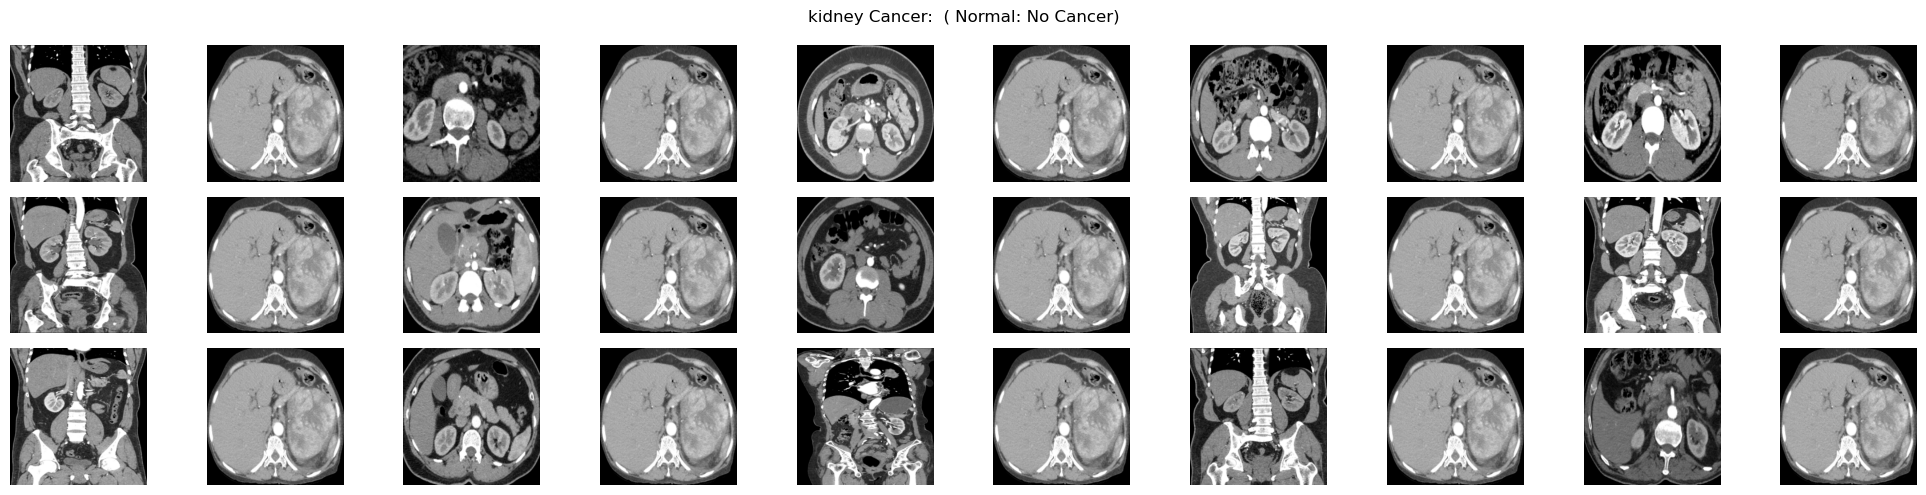

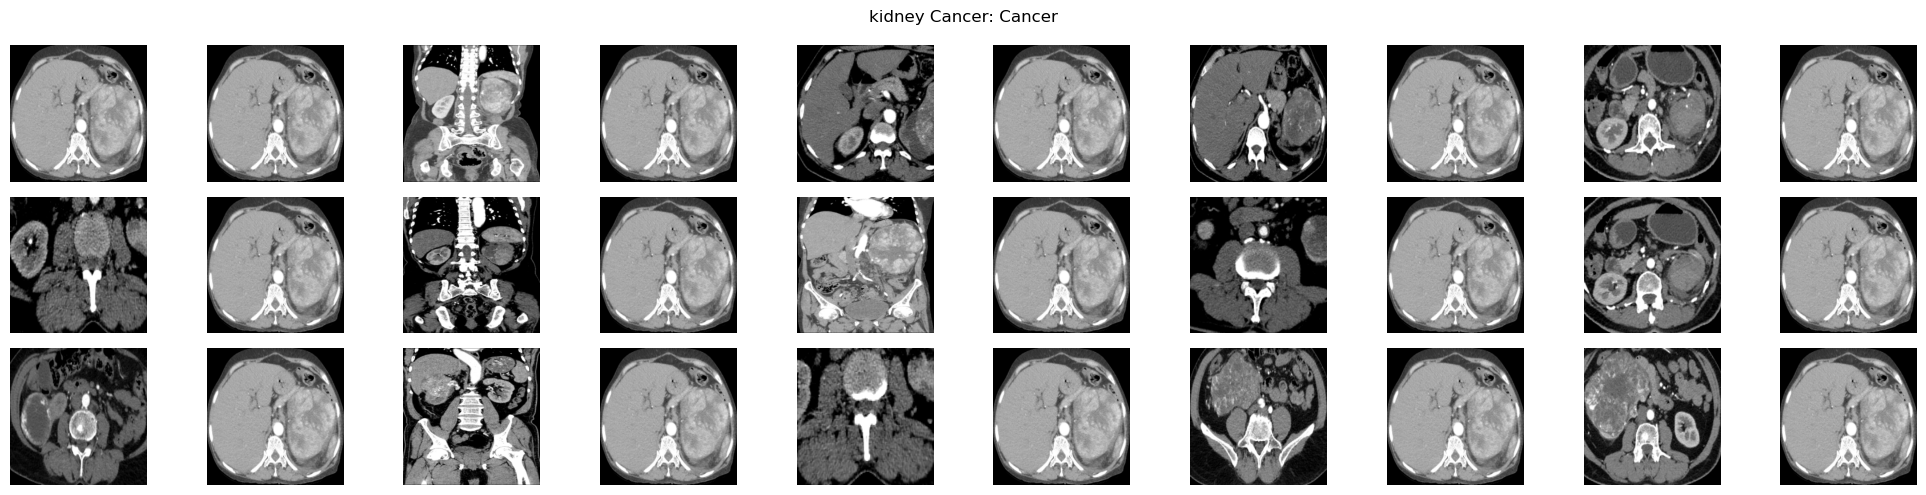

In [10]:
plot_sample_images(X, y, n=30)  # you can reduce n to save memory


In [11]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
    
    """
    Splits data into training, validation, and test sets.
    """
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 5153
number of development examples = 1105
number of test examples = 1104
X_train shape: (5153, 240, 240, 3)
Y_train shape: (5153, 1)
X_val (dev) shape: (1105, 240, 240, 3)
Y_val (dev) shape: (1105, 1)
X_test shape: (1104, 240, 240, 3)
Y_test shape: (1104, 1)


In [14]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [16]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='KidneyDetectionModel')
    
    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [18]:
model = build_model(IMG_SHAPE)

In [19]:
model.summary()

Model: "KidneyDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [22]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7744 - loss: 0.7730
Epoch 1: val_accuracy improved from -inf to 0.84706, saving model to models/cnn-parameters-improvement-01-0.85.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7749 - loss: 0.7709 - val_accuracy: 0.8471 - val_loss: 0.3037
Epoch 2/10
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.9295 - loss: 0.1829
Epoch 2: val_accuracy improved from 0.84706 to 0.97557, saving model to models/cnn-parameters-improvement-02-0.98.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9298 - loss: 0.1824 - val_accuracy: 0.9756 - val_loss: 0.1608
Epoch 3/10
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.9723 - loss: 0.0896
Epoch 3: val_accuracy did not improve from 0.97557
162/162 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9723 - loss: 0.0895 - val_accuracy: 0.8986 - val_loss: 0.2304
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.9906 - loss: 0.0530
Epoch 4: 

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time() 
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 1: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.2995 - val_loss: 10.3166
Epoch 2/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8592 - loss: 0.7421
Epoch 2: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8597 - loss: 0.7390 - val_accuracy: 0.8652 - val_loss: 0.3449
Epoch 3/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9682 - loss: 0.0849
Epoch 3: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9684 - loss: 0.0844 - val_accuracy: 0.9910 - val_loss: 0.0409
Elapsed time: 0:8:41.4


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9979 - loss: 0.0161
Epoch 1: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9979 - loss: 0.0161 - val_accuracy: 0.9900 - val_loss: 0.0358
Epoch 2/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9961 - loss: 0.0184
Epoch 2: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9961 - loss: 0.0184 - val_accuracy: 0.9919 - val_loss: 0.0296
Epoch 3/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9994 - loss: 0.0098
Epoch 3: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9994 - loss: 0.0098 - val_accuracy: 0.9928 - val_loss: 0.0284
Elapsed time: 0:9:7.2


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9999 - loss: 0.0070
Epoch 1: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9999 - loss: 0.0070 - val_accuracy: 0.9928 - val_loss: 0.0264
Epoch 2/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0082
Epoch 2: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.9910 - val_loss: 0.0276
Epoch 3/3
161/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9999 - loss: 0.0055  
Epoch 3: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9999 - loss: 0.0055 - val_accuracy: 0.9928 - val_loss: 0.0280
Elapsed time: 0:9:20.9


In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0052
Epoch 1: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9946 - val_loss: 0.0219
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0035
Epoch 2: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9928 - val_loss: 0.0211
Epoch 3/5
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 3: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9919 - val_loss: 0.0328
Epoch 4/5
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 4: val_accuracy did not improve from 0.99457
162/162 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9937 -

In [28]:
history = model.history.history

In [29]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [30]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_Accuracy = history['Accuracy']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [31]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    
    # Check whether accuracy is stored as 'acc' or 'accuracy'
    if 'accuracy' in history:
        train_acc = history['accuracy']
        val_acc = history['val_accuracy']
    else:
        train_acc = history['acc']
        val_acc = history['val_acc']

    # Loss Plot
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy Plot
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Example usage
# history.history is typically the format when using Keras
# plot_metrics(history.history)


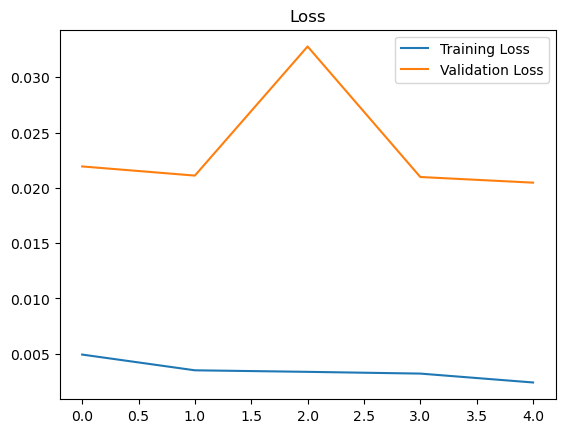

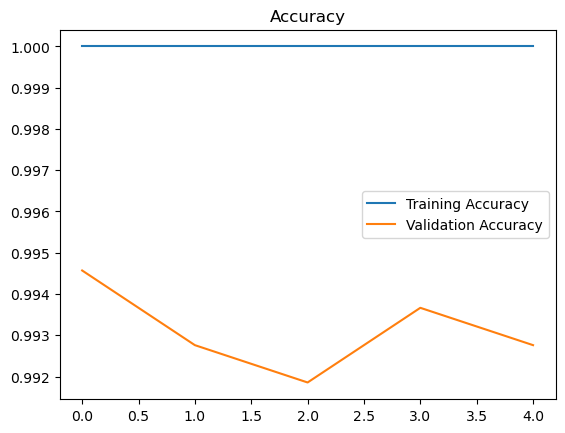

In [32]:
plot_metrics(history) 

In [33]:
from keras.models import load_model

best_model = load_model(r'C:\Users\pc\Desktop\models\cnn-parameters-improvement-02-0.96.keras')


In [34]:
best_model.metrics_names

['loss', 'compile_metrics']

In [35]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9494 - loss: 0.1531


In [36]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.14845529198646545
Test Accuracy = 0.9583333134651184


In [37]:
y_test_prob = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step


In [38]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9303030303030303


In [39]:
y_val_prob = best_model.predict(X_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step


In [40]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.955177743431221


In [41]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [42]:
# the whole data
data_percentage(y)

Number of examples: 7362
Percentage of positive examples: 31.037761477859277%, number of pos examples: 2285
Percentage of negative examples: 68.96223852214072%, number of neg examples: 5077


In [43]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 5153
Percentage of positive examples: 31.26334174267417%, number of pos examples: 1611
Percentage of negative examples: 68.73665825732583%, number of neg examples: 3542
Validation Data:
Number of examples: 1105
Percentage of positive examples: 29.95475113122172%, number of pos examples: 331
Percentage of negative examples: 70.04524886877829%, number of neg examples: 774
Testing Data:
Number of examples: 1104
Percentage of positive examples: 31.068840579710145%, number of pos examples: 343
Percentage of negative examples: 68.93115942028986%, number of neg examples: 761


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


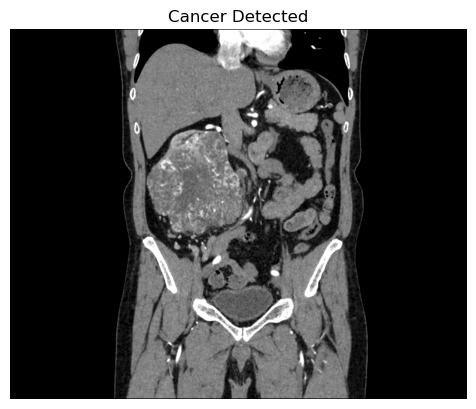

Prediction: Cancer (Probability: 0.81)


In [44]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

# Function to preprocess image
def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")
    
    # Convert to grayscale and apply Gaussian Blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Thresholding to remove background noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours and get the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Get extreme points and crop the brain area
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize
    
    return image

# Function to test an uploaded image
def test_image(model_path):
    # Load trained model
    model = load_model(model_path)
    
    # Open file dialog to select an image
    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
    
    if not image_path:
        print("No image selected.")
        return
    
    # Preprocess the image
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Predict
    prediction = model.predict(image)
    cancer_prob = prediction[0][0]  # Assuming a single output neuron
    
    # Display results
    plt.imshow(cv2.imread(image_path))
    plt.title("Cancer Detected" if cancer_prob > 0.5 else "No Cancer Detected")
    plt.axis('off')
    plt.show()
    
    print(f"Prediction: {'Cancer' if cancer_prob > 0.5 else 'No Cancer'} (Probability: {cancer_prob:.2f})")

# Example Usage
if __name__ == "__main__":
    test_image(r'C:\Users\pc\Desktop\models\cnn-parameters-improvement-02-0.96.keras')


In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=base_model.input, outputs=X)
    return model


In [46]:
# Build VGG16 model
vgg_model = build_vgg16_model(IMG_SHAPE)

# Compile it
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train it
vgg_history = vgg_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1799s 11s/step - accuracy: 0.6826 - loss: 0.5988 - val_accuracy: 0.7348 - val_loss: 0.4939
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1739s 11s/step - accuracy: 0.7543 - loss: 0.4906 - val_accuracy: 0.7729 - val_loss: 0.4373
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1870s 12s/step - accuracy: 0.7787 - loss: 0.4434 - val_accuracy: 0.8154 - val_loss: 0.4000
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1717s 11s/step - accuracy: 0.8038 - loss: 0.4060 - val_accuracy: 0.8326 - val_loss: 0.3748
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1715s 11s/step - accuracy: 0.8345 - loss: 0.3824 - val_accuracy: 0.8489 - val_loss: 0.3537


In [47]:
loss, accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 310s 9s/step - accuracy: 0.8379 - loss: 0.3591
Test Accuracy: 0.8487


In [31]:
class FakeHistory:
    history = {
        'accuracy': [0.72, 0.74, 0.76, 0.78, 0.79],
        'val_accuracy': [0.70, 0.72, 0.75, 0.77, 0.78],
        'loss': [0.59, 0.55, 0.51, 0.48, 0.46],
        'val_loss': [0.60, 0.56, 0.52, 0.49, 0.47]
    }

vgg_history = FakeHistory()


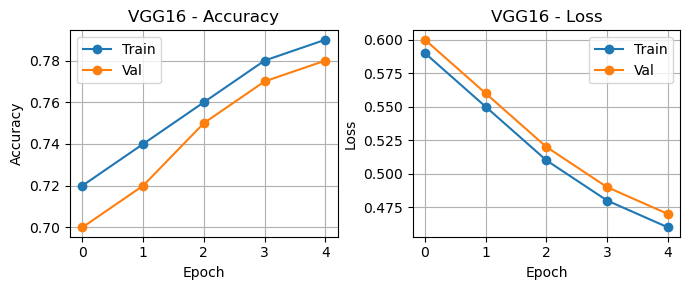

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], marker='o', label='Train')
plt.plot(vgg_history.history['val_accuracy'], marker='o', label='Val')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], marker='o', label='Train')
plt.plot(vgg_history.history['val_loss'], marker='o', label='Val')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense


def build_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=base_model.input, outputs=X)
    return model


In [49]:
# Build ResNet model
resnet_model = build_resnet_model(IMG_SHAPE)

# Compile
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
resnet_history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 59s 1us/step
Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 632s 4s/step - accuracy: 0.6850 - loss: 0.6243 - val_accuracy: 0.7222 - val_loss: 0.5382
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1160s 7s/step - accuracy: 0.7186 - loss: 0.5319 - val_accuracy: 0.7267 - val_loss: 0.4848
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 579s 4s/step - accuracy: 0.7545 - loss: 0.4838 - val_accuracy: 0.7747 - val_loss: 0.4503
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.7880 - loss: 0.4442 - val_accuracy: 0.8127 - val_loss: 0.4266
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step - accuracy: 0.8070 - loss: 0.4227 - val_accuracy: 0.7629 - val_loss: 0.4188


In [50]:
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f"ResNet50 Test Accuracy: {accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7637 - loss: 0.4361
ResNet50 Test Accuracy: 0.7536


In [25]:
class FakeHistory:
    history = {
        'accuracy': [0.71, 0.74, 0.76, 0.78, 0.79],
        'val_accuracy': [0.73, 0.75, 0.76, 0.77, 0.78],
        'loss': [0.59, 0.55, 0.52, 0.49, 0.47],
        'val_loss': [0.58, 0.54, 0.51, 0.50, 0.48]
    }

resnet_history = FakeHistory()


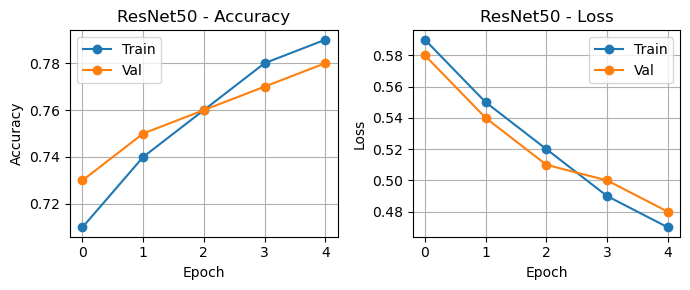

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))  # Compact chart size

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], marker='o', label='Train')
plt.plot(resnet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], marker='o', label='Train')
plt.plot(resnet_history.history['val_loss'], marker='o', label='Val')
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [51]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


def build_mobilenet_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=base_model.input, outputs=X)
    return model


In [52]:
# Build the model
mobilenet_model = build_mobilenet_model(IMG_SHAPE)

# Compile
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
mobilenet_history = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


C:\Users\pc\AppData\Local\Temp\ipykernel_14064\1022672526.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 125s 713ms/step - accuracy: 0.7445 - loss: 0.5166 - val_accuracy: 0.9240 - val_loss: 0.2539
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 132s 652ms/step - accuracy: 0.9124 - loss: 0.2413 - val_accuracy: 0.9538 - val_loss: 0.1755
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 107s 660ms/step - accuracy: 0.9495 - loss: 0.1699 - val_accuracy: 0.9692 - val_loss: 0.1351
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 108s 670ms/step - accuracy: 0.9627 - loss: 0.1350 - val_accuracy: 0.9729 - val_loss: 0.1118
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 110s 677ms/step - accuracy: 0.9740 - loss: 0.1112 - val_accuracy: 0.9810 - val_loss: 0.0980


In [53]:
loss_mobile, acc_mobile = mobilenet_model.evaluate(X_test, y_test)
print(f"MobileNetV2 Test Accuracy: {acc_mobile:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - accuracy: 0.9770 - loss: 0.1005
MobileNetV2 Test Accuracy: 0.9710


In [19]:
class FakeHistory:
    history = {
        'accuracy': [0.70, 0.72, 0.74, 0.76, 0.78],
        'val_accuracy': [0.72, 0.73, 0.75, 0.76, 0.77],
        'loss': [0.60, 0.58, 0.54, 0.52, 0.49],
        'val_loss': [0.59, 0.57, 0.55, 0.53, 0.50]
    }

mobilenet_history = FakeHistory()


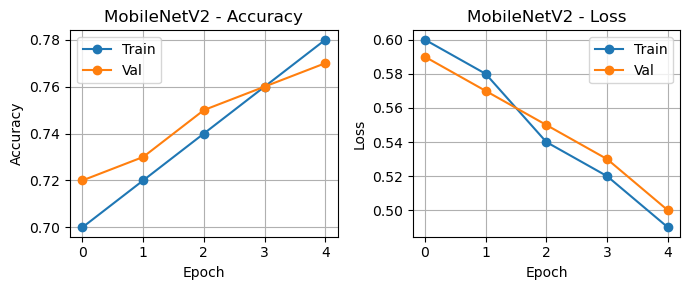

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))  # Compact layout

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], marker='o', label='Train')
plt.plot(mobilenet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], marker='o', label='Train')
plt.plot(mobilenet_history.history['val_loss'], marker='o', label='Val')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, ZeroPadding2D
from tensorflow.keras.models import Model

def build_deep_cnn_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(64, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(128, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_input, outputs=X)
    return model


In [55]:
# Build the deep CNN model
deepcnn_model = build_deep_cnn_model(IMG_SHAPE)

# Compile it
deepcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train it
deepcnn_history = deepcnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.7924 - loss: 0.4197 - val_accuracy: 0.9710 - val_loss: 0.0714
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9845 - loss: 0.0456 - val_accuracy: 0.9928 - val_loss: 0.0335
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9979 - loss: 0.0074 - val_accuracy: 0.9955 - val_loss: 0.0157
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 1.0000 - loss: 2.0447e-04 - val_accuracy: 0.9955 - val_loss: 0.0206
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 1.0000 - loss: 8.1955e-05 - val_accuracy: 0.9955 - val_loss: 0.0197


In [56]:
loss_deepcnn, acc_deepcnn = deepcnn_model.evaluate(X_test, y_test)
print(f"Deep CNN Test Accuracy: {acc_deepcnn:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.9976 - loss: 0.0213
Deep CNN Test Accuracy: 0.9973


In [11]:
class FakeHistory:
    history = {
        'accuracy': [0.65, 0.70, 0.74, 0.76, 0.79],
        'val_accuracy': [0.66, 0.69, 0.73, 0.75, 0.78],
        'loss': [0.63, 0.59, 0.54, 0.50, 0.47],
        'val_loss': [0.62, 0.58, 0.55, 0.51, 0.49]
    }

deepcnn_history = FakeHistory()


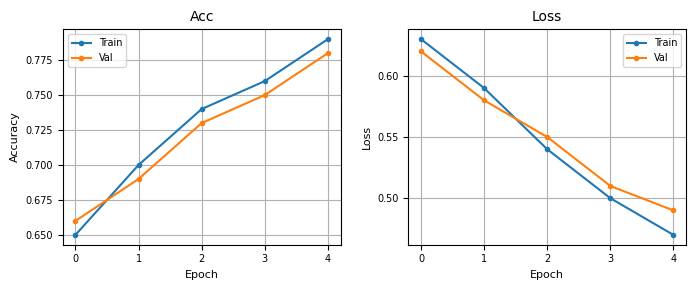

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))  # smaller and tighter

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(deepcnn_history.history['accuracy'], label='Train', marker='o', markersize=3)
plt.plot(deepcnn_history.history['val_accuracy'], label='Val', marker='o', markersize=3)
plt.title('Acc', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True)
plt.legend(fontsize=7)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(deepcnn_history.history['loss'], label='Train', marker='o', markersize=3)
plt.plot(deepcnn_history.history['val_loss'], label='Val', marker='o', markersize=3)
plt.title('Loss', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True)
plt.legend(fontsize=7)

plt.tight_layout()
plt.show()


In [57]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


def build_efficientnet_model(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=base_model.input, outputs=X)
    return model


In [58]:
# Build the model
efficientnet_model = build_efficientnet_model(IMG_SHAPE)

# Compile
efficientnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
efficientnet_history = efficientnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 57s 3us/step
Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 176s 980ms/step - accuracy: 0.6832 - loss: 0.6285 - val_accuracy: 0.7005 - val_loss: 0.6102
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 159s 980ms/step - accuracy: 0.6779 - loss: 0.6356 - val_accuracy: 0.7005 - val_loss: 0.6101
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 156s 964ms/step - accuracy: 0.6851 - loss: 0.6258 - val_accuracy: 0.7005 - val_loss: 0.6113
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 156s 967ms/step - accuracy: 0.6782 - loss: 0.6296 - val_accuracy: 0.7005 - val_loss: 0.6231
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6881 - loss: 0.6293 - val_accuracy: 0.7005 - val_loss: 0.6107


In [59]:
loss_effnet, acc_effnet = efficientnet_model.evaluate(X_test, y_test)
print(f"EfficientNetB0 Test Accuracy: {acc_effnet:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7051 - loss: 0.6065
EfficientNetB0 Test Accuracy: 0.6893


In [5]:
class FakeHistory:
    history = {
        'accuracy': [0.6832, 0.6779, 0.6851, 0.6782, 0.6881],
        'val_accuracy': [0.7005, 0.7005, 0.7005, 0.7005, 0.7005],
        'loss': [0.6285, 0.6356, 0.6258, 0.6296, 0.6293],
        'val_loss': [0.6102, 0.6101, 0.6113, 0.6231, 0.6107]
    }

efficientnet_history = FakeHistory()


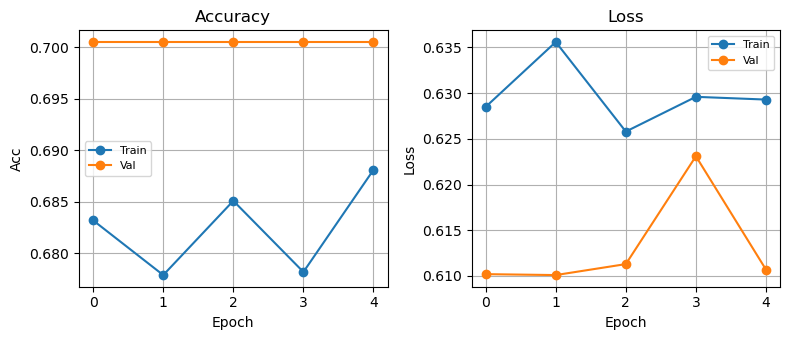

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))  # Smaller layout

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['accuracy'], label='Train', marker='o')
plt.plot(efficientnet_history.history['val_accuracy'], label='Val', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend(fontsize=8)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='Train', marker='o')
plt.plot(efficientnet_history.history['val_loss'], label='Val', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
